In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
import regex as re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline

In [2]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import ngrams

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:
pd.set_option('display.max_rows', 500)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
products = pd.read_csv('/content/drive/MyDrive/Unstructured Assignment 2/products_complete.csv')
reviews = pd.read_csv('/content/drive/MyDrive/Unstructured Assignment 2/scraped_data3.csv')

In [6]:
products.head()

,product,link,features,description,review_pages
0,Men's Lightweight Waterproof Hooded Rain Jacke...,/gp/slredirect/picassoRedirect.html/ref=pa_sp_...,100% Polyester Imported Polyester lining Zipp...,This waterproof ski jacket is made of 100% po...,/Lightweight-Waterproof-Hooded-Outdoor-Raincoa...
1,Men's Full-Zip Polar Fleece Jacket,/Amazon-Essentials-Full-Zip-Fleece-Jacket/dp/B...,100% Polyester Imported Zipper closure Machin...,Amazon Essentials is focused on creating affo...,/Amazon-Essentials-Full-Zip-Fleece-Jacket/prod...
2,mens Ascender Softshell Front-zip Jacket,/Columbia-Ascender-Softshell-Jacket-Resistant/...,100% Polyester Imported Zipper closure Machin...,There's nothing more necessary than a wind an...,/Columbia-Ascender-Softshell-Front-Zip-Jacket/...
3,Men's Watertight Ii Jacket,/Columbia-Watertight-Jacket-Black-Large/dp/B00...,Shell: 100% Nylon; Lining: 100% Polyester Imp...,Columbia's rain jackets work around the clock...,/Columbia-Mens-Watertight-Ii-Jacket/product-re...
4,Men's Slim Fit Lightweight Sportswear Jacket C...,/URBANFIND-Lightweight-Sportswear-Jacket-Casua...,100% Polyester Imported Zipper closure slim f...,100% Polyester Tips: If you are strong and ta...,/URBANFIND-Lightweight-Sportswear-Jacket-Casua...


In [7]:
reviews.head()

,product,review_title,review_rating,review_text
0,Men's Lightweight Waterproof Hooded Rain Jacke...,"Excellent price, actually waterproof, lightwei...",5,Your browser does not support HTML5 video.\n\n...
1,Men's Lightweight Waterproof Hooded Rain Jacke...,Actually pretty good.,5,I ordered an XL thinking that it would run sma...
2,Men's Lightweight Waterproof Hooded Rain Jacke...,NOT WATERPROOF,1,"I wanted to like this jacket, I'm tall and hav..."
3,Men's Lightweight Waterproof Hooded Rain Jacke...,Good Jacket to wear over warm clothes,5,"A great rain coat for the price. Beware, howev..."
4,Men's Lightweight Waterproof Hooded Rain Jacke...,Poor cuff closure design.,3,I'm 5'9 165lbs and I ordered a medium. It fits...


# data cleaning

In [8]:
review_mapping = pd.DataFrame(reviews['product'].unique(), columns=['product_name'])

In [9]:
def find_product_id(string):
  for i in range(len(products)):
    if products['product'].iloc[i] in string:
      return i
  return -1

In [10]:
review_mapping['prouduct_id'] = review_mapping['product_name'].apply(find_product_id)

In [11]:
review_map= {}
for i in range(len(review_mapping)):
  review_map[review_mapping['product_name'].iloc[i]] = review_mapping['prouduct_id'].iloc[i]

# Figuring out key features in "Jackets for men"

In [12]:
cleaning = {'pockets' : 'pocket', 'zippered' : 'zip', 'zipper' : 'zip', 
            'zippers' : 'zip', 'comfortable' : 'comfort', 'fits' : 'fit',
            'warmth' : 'warm', 'sleeves' : 'sleeve', 'hoodie' : 'hood', 
            'shoulders' : 'shoulder', 'lightweight' : 'light'}

In [13]:
def clean_text(string):
    if pd.isna(string):
        return ""
    string = string.lower()
    string = string.replace("\n", " ").replace("\t", " ")
    string = re.sub(r'[^\w]', ' ', string)

    for original, new_word in cleaning.items():
      string = string.replace(original, new_word)
    return string

### Key things that Amazon Sellers talk about

In [14]:
products['cleaned_features'] = products['features'].apply(clean_text)
products['cleaned_description'] = products['description'].apply(clean_text)

In [15]:
description_corpus = ""

for desc in products['cleaned_description']:
  description_corpus = description_corpus + " " + desc

In [16]:
feature_corpus = ""

for feature in products['cleaned_features']:
  feature_corpus = feature_corpus + " " + feature

In [17]:
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform([description_corpus])
word_count = pd.Series(X.toarray()[0], index=vectorizer.get_feature_names())

In [18]:
ranked_word_count = word_count.sort_values(ascending=False)
ranked_word_count.to_csv('/content/drive/MyDrive/Unstructured Assignment 2/word_freq_desc.csv')

In [19]:
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform([feature_corpus])
word_count = pd.Series(X.toarray()[0], index=vectorizer.get_feature_names())
ranked_word_count = word_count.sort_values(ascending=False)
ranked_word_count.to_csv('/content/drive/MyDrive/Unstructured Assignment 2/word_freq_features.csv')

In [20]:
# not in order
key_features_seller = ['pocket', 'fit', 'zip', 
                       'waterproof', 'style', 'hood', 'warm', 'size',
                       'chest', 'sleeve', 'fleece', 'rain', 
                       'fabric', 'quality', 'comfort',
                       'light', 'lining']

### Key things that customers talk about

In [21]:
reviews['cleaned_reviews'] = reviews['review_text'].apply(clean_text)

In [22]:
review_corpus = ""

for review in reviews['cleaned_reviews']:
  review_corpus = review_corpus + " " + review

In [23]:
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform([review_corpus])
word_count = pd.Series(X.toarray()[0], index=vectorizer.get_feature_names())
ranked_word_count = word_count.sort_values(ascending=False)
ranked_word_count.to_csv('/content/drive/MyDrive/Unstructured Assignment 2/word_freq_reviews.csv')

In [24]:
# not in order
key_features_customers = ['fit', 'size', 'warm', 'quality', 'pocket', 'rain', 
                          'price', 'waterproof', 'hood', 'outdoor', 
                          'zip', 'chest', 'sleeve', 'fleece', 'rain', 
                          'material', 'comfort', 'shoulder', 'heavy']

### Key Features Overall

In [25]:
features = list(set(key_features_seller) | set(key_features_customers))
features

['material',
 'sleeve',
 'light',
 'price',
 'fit',
 'style',
 'waterproof',
 'quality',
 'hood',
 'lining',
 'size',
 'pocket',
 'heavy',
 'chest',
 'zip',
 'outdoor',
 'shoulder',
 'comfort',
 'fabric',
 'rain',
 'warm',
 'fleece']

# Sentiment Analysis

## Overall Vader perfromance check

In [26]:
analyzer = SentimentIntensityAnalyzer()

# let's check how vader performs on sentence
print("This jacket is great.", analyzer.polarity_scores("This jacket is great."))
print("This jacket's fit is great.", analyzer.polarity_scores("This jacket's fit is great."))
print("This jacket is not warm enough", analyzer.polarity_scores("This jacket is not warm enough"))
print("", analyzer.polarity_scores(""))

This jacket is great. {'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'compound': 0.6249}
This jacket's fit is great. {'neg': 0.0, 'neu': 0.312, 'pos': 0.688, 'compound': 0.765}
This jacket is not warm enough {'neg': 0.25, 'neu': 0.75, 'pos': 0.0, 'compound': -0.1695}
 {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}


Let's see how well the rating is correlated with vader scores

In [27]:
reviews['review_text'] = reviews['review_text'].apply(lambda s: "" if pd.isna(s) else s)
reviews['review_title'] = reviews['review_title'].apply(lambda s: "" if pd.isna(s) else s)

reviews['sent_score_cleaned'] = reviews['cleaned_reviews'].apply(lambda s: analyzer.polarity_scores(s)['compound'])
reviews['sent_score'] = reviews['review_text'].apply(lambda s: analyzer.polarity_scores(s)['compound'])
reviews['sent_score_title'] = reviews['review_title'].apply(lambda s: analyzer.polarity_scores(s)['compound'])

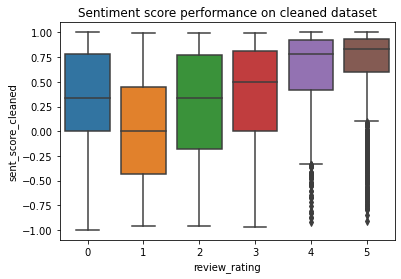

In [28]:
sns.boxplot(data = reviews, y = 'sent_score_cleaned', x = 'review_rating').set(title='Sentiment score performance on cleaned dataset')
plt.show()

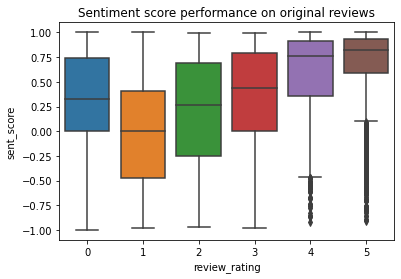

In [29]:
sns.boxplot(data = reviews, y = 'sent_score', x = 'review_rating').set(title='Sentiment score performance on original reviews')
plt.show()

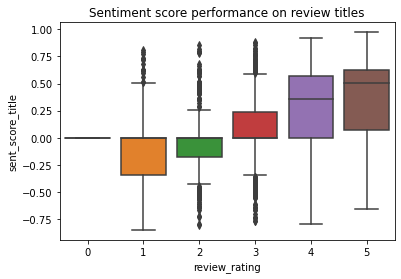

In [30]:
sns.boxplot(data = reviews, y = 'sent_score_title', x = 'review_rating').set(title='Sentiment score performance on review titles')
plt.show()

In [31]:
# we are using this ot find the optimal n to use for n-gram

rf = RandomForestClassifier()
rf.fit(reviews[['sent_score_cleaned']], reviews['review_rating'])
print("Accuracy of fit - ", rf.score(reviews[['sent_score_cleaned']], reviews['review_rating']))

Accuracy of fit -  0.7223997808419322


Looks like vader sentiment scorer is performing well for ratings in general. For zero rating, there seems to be some ambiguity. <br>

Looks like title has good amount information about the customer is feeling in general

## Performance on at attribute level

In [32]:
## given a sentence extract all features in ngram mode
def extract_n_grams(n, features, sentence):
  n_grams = {}

  #initialisation
  for feature in features:
    n_grams[feature] = []

  if len(sentence) == 0:
    return n_grams

  if len(sentence.split()) < n:
    for feature in features:
      if feature in sentence:
        n_grams[feature] = n_grams[feature] + [sentence]

    
    return n_grams

  temp = ngrams(sentence.split(), n)

  for tupl in temp:
    for feature in features:
      string = ' '.join(list(tupl))
      if feature in string:
        n_grams[feature] = n_grams[feature] + [string]
  
  return n_grams

In [33]:
def avg_sentiment_score(list_string):
  if len(list_string) == 0:
    return 0
  
  score = 0
  for string in list_string:
    score = score + analyzer.polarity_scores(string)['compound']
  
  return np.average(score)

In [34]:
# highest accuracy for predicting rating achieved when title was added.
# more complex combinations can also be explored in which title is given more advantage. 
# Right now, review body is domintaing because body is going to have longer text.
# Some ideas of increasing domninance - 1. use weighted average of sentiment scores
# 2. Add title twice in all content column

reviews['all_content'] = reviews['review_title'] + " " + reviews['cleaned_reviews']

In [35]:
review_sentiment = pd.DataFrame(np.zeros((len(reviews), len(features))), columns = features)

for i in range(len(review_sentiment)):

  try: 
    n_grams = extract_n_grams(5, features, reviews['all_content'].iloc[i])
  except:
    print(reviews['cleaned_reviews'].iloc[i])
  for feature in features:
    review_sentiment[feature].iloc[i] = avg_sentiment_score(n_grams[feature])

In [36]:
review_sentiment.head(2)

,material,sleeve,light,price,fit,style,waterproof,quality,hood,lining,size,pocket,heavy,chest,zip,outdoor,shoulder,comfort,fabric,rain,warm,fleece
0,0.0,0.0,2.4466,0.5719,0.0,0.0,0.5719,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0
1,0.0,0.0,0.0000,0.0000,0.0,0.0,0.6768,0.0,0.0,0.0,0.0,0.101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.9052,0.0


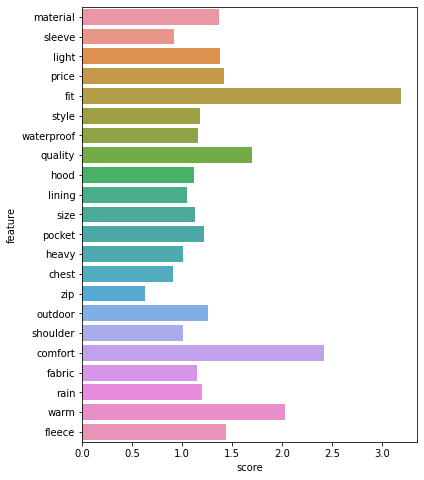

In [37]:
series = review_sentiment > 0
series = series.sum()
s = review_sentiment.sum() / series
s = s.reset_index()
s.columns = ['feature', 'score']
plt.figure(figsize=(6,8))
sns.barplot(data = s, y = 'feature', x = 'score')

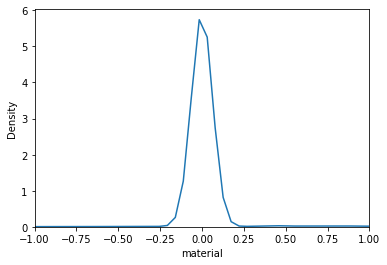

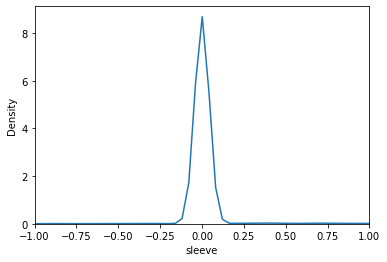

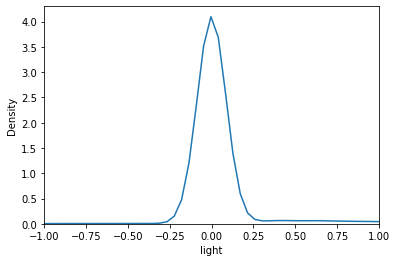

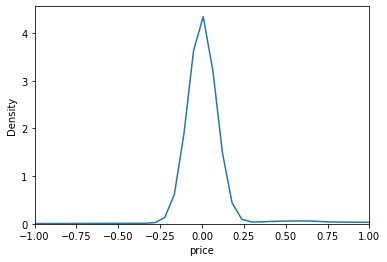

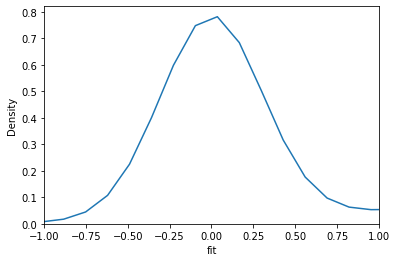

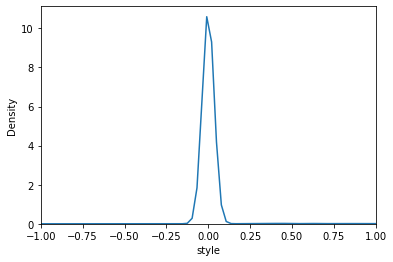

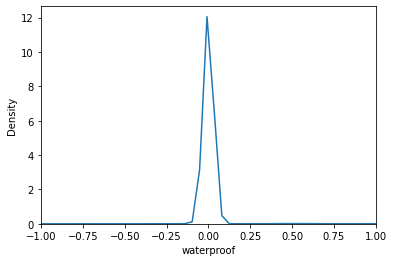

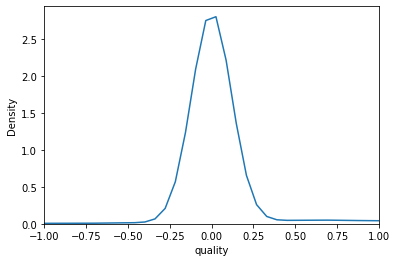

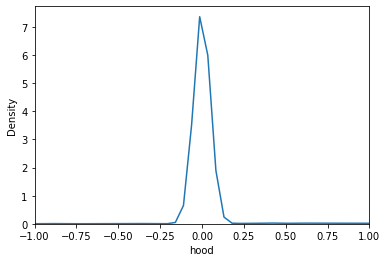

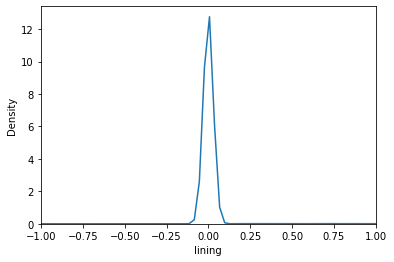

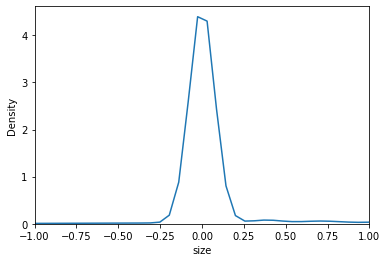

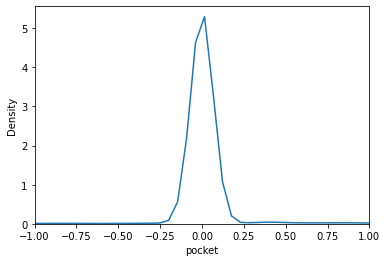

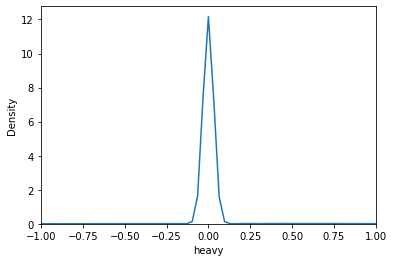

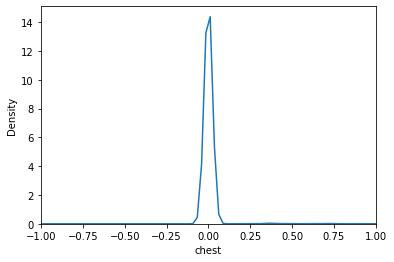

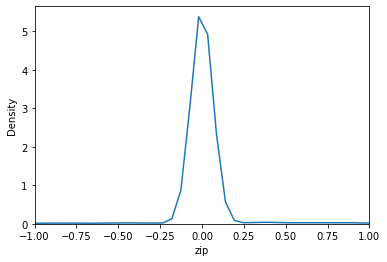

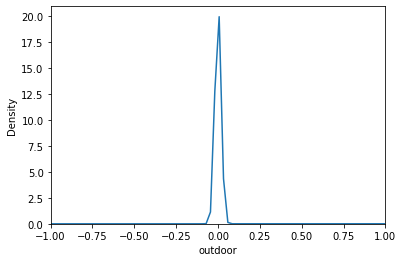

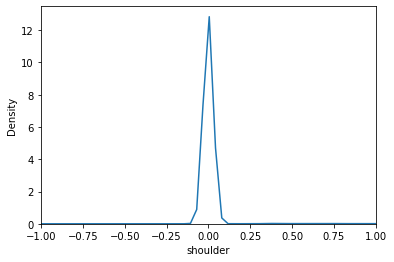

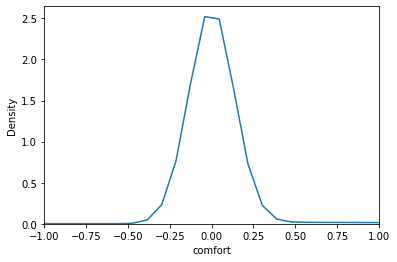

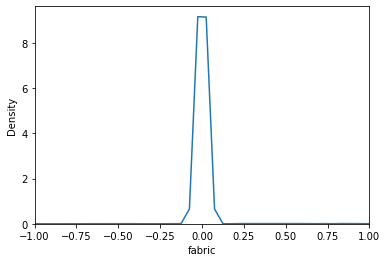

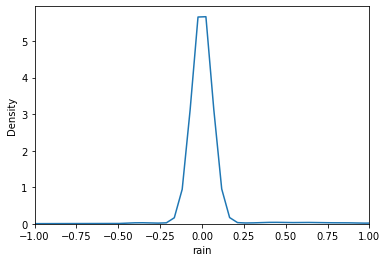

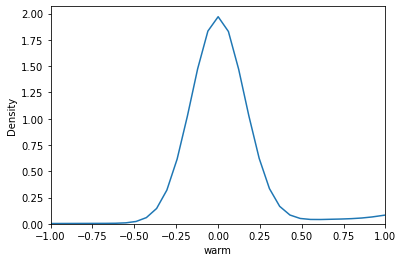

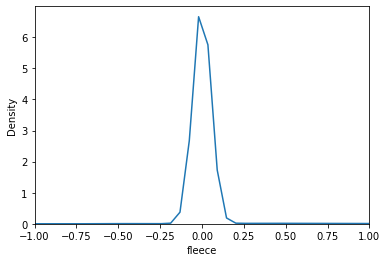

In [38]:
for f in features:
  sns.kdeplot(data=review_sentiment, x=f)
  plt.xlim([-1,1])
  plt.show()

# Feature Importance

Accuracy of fit -  0.8514290932334947


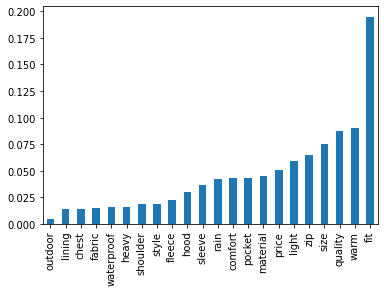

In [39]:
# we are using this ot find the optimal n to use for n-gram

rf = RandomForestClassifier()
rf.fit(review_sentiment, reviews['review_rating'])
print("Accuracy of fit - ", rf.score(review_sentiment, reviews['review_rating']))
pd.Series(index = features, data = rf.feature_importances_).sort_values().plot(kind = 'bar')

# Product recommendation based on product reviews

In [40]:
review_sentiment['product'] = reviews['product']

In [41]:
product_sentiment = pd.pivot_table(data = review_sentiment, index='product', 
                                   values=features, aggfunc=np.mean).reset_index()
product_sentiment.sample(5)

,product,chest,comfort,fabric,fit,fleece,heavy,hood,light,lining,material,outdoor,pocket,price,quality,rain,shoulder,size,sleeve,style,warm,waterproof,zip
62,The North Face Men's Junction Insulated Jacket,0.007250,0.130291,0.000000,0.455271,0.000000,0.000000,0.000000,0.252829,0.000000,0.020148,0.000000,-0.015244,0.069268,0.101793,0.033017,0.000000,0.190181,0.000000,0.000000,0.763655,0.000000,0.000000
6,BALEAF Men's Cycling Running Jacket Waterproof...,0.004939,0.139953,0.021900,0.937697,-0.005418,-0.005920,0.046798,0.183139,-0.007683,0.124621,0.024826,0.198162,0.040723,0.062884,0.210433,0.014785,0.114676,0.044637,0.003185,0.291920,0.051958,0.088041
55,TACVASEN Men's Jacket-Lightweight Casual Sprin...,0.001806,0.158733,0.007742,0.791678,0.000000,0.016406,0.009351,0.228184,0.007963,0.029781,0.000000,0.015492,0.111735,0.256879,-0.000706,0.010918,0.065603,0.005260,0.038677,0.093419,0.000000,0.034908
23,Columbia Men’s Timberline Triple Interchange W...,0.000000,0.370190,0.000000,1.028079,0.142304,0.000000,0.076717,0.082971,0.058097,0.021487,0.000000,0.095044,0.146750,0.191824,0.061814,0.048463,0.127439,0.066716,0.015480,0.890084,0.035371,0.054146
73,Wantdo Men's Faux Leather Jacket with Removabl...,0.027971,0.343930,0.000258,1.676747,0.000000,0.072091,0.147580,0.043773,0.016220,0.141359,0.014562,0.069949,0.213252,0.365221,0.010732,0.022633,0.150707,0.029936,0.069710,0.761921,0.000000,0.030593


In [42]:
def top_n_products(imp_attributes, n):

  vector = [imp_attributes[feature] if feature in imp_attributes else 0 for feature in features]
  vector = np.array(vector)

  cosine_scores = cosine_similarity(vector.reshape(1,-1), product_sentiment[features])[0]

  top_n = pd.Series(index = product_sentiment['product'],
                     data = cosine_scores).sort_values(ascending = False)[:n]

  return top_n

In [43]:
top_n_products({'zip': 1, 
                'quality':1, 
                'price':2, 
                'fit':1}, 20)

product
TOTNMC Men's Casual Coats for men Slim Fit Softshell Jacket Winter Fall Jacket Mens Windbreakers Bomber Jacket,Grey,X-Large    0.632076
TACVASEN Lightweight Jacket for Men Softshell Fall Thin Bomber Coat, Black 2XL                                                 0.580419
Mastermind - Men's Leather Motorcycle Jacket                                                                                   0.578248
Amazon Essentials Men's Lightweight Bomber Jacket                                                                              0.572436
Champion Men's Packable Jacket                                                                                                 0.561019
TACVASEN Men's Jacket-Lightweight Thin Sportwear Varsity Jacket, Green M                                                       0.552284
TACVASEN Men's Jacket-Lightweight Casual Spring Fall Thin Bomber Zip Pockets Coat Outwear                                      0.552284
Columbia Men's Utilizer Jacket, Collegia

# Product description vectors

In [44]:
products['all_data'] = products['cleaned_features'] + " " + products['cleaned_description']

In [45]:
def check_product_name(string):
  for name in list(review_mapping['product_name']):
    if string in name:
      return True 
  return False

In [46]:
filtered_products = products[products['product'].apply(check_product_name)]
filtered_products.sample(5)

,product,link,features,description,review_pages,cleaned_features,cleaned_description,all_data
107,Men's Short Sleeve Launch Cage Jacket,/Rawlings-LNCCJ-N-93-Navy-3X-Large/dp/B07DWXS3...,Zipper closure Stretch fabric construction fo...,RawlingsA Men's Short Sleeve Launch Cage Jack...,/Rawlings-Short-Sleeve-Launch-Jacket/product-r...,zip closure stretch fabric construction for e...,rawlingsa men s short sleeve launch cage jack...,zip closure stretch fabric construction for e...
7,Men's Steens Mountain 2.0 Full Zip Fleece Jacket,/Columbia-Steens-Mountain-Fleece-Jacket/dp/B00...,100% Polyester Imported Zipper closure Machin...,"The next generation of a Columbia classic, th...",/Columbia-Steens-Mountain-Fleece-Jacket/produc...,100 polyester imported zip closure machine w...,the next generation of a columbia classic th...,100 polyester imported zip closure machine w...
85,Men's Tiro 21 Track Jacket,/adidas-Track-Jacket-Power-Medium/dp/B089K8FWZ...,100% Polyester Imported Men's track jacket fo...,Don't limit your soccer style to the field. T...,/adidas-mens-Tiro-Track-Jacket/product-reviews...,100 polyester imported men s track jacket fo...,don t limit your soccer style to the field t...,100 polyester imported men s track jacket fo...
36,Men's Rugged Wear Unlined Denim Jacket,/Wrangler-Rugged-Unlined-Jacket-Vintage/dp/B00...,100% Cotton Imported Button closure Machine W...,Wrangler Men's Rugged Wear Unlined Denim Jack...,/Wrangler-Rugged-Unlined-Denim-Jacket/product-...,100 cotton imported button closure machine w...,wrangler men s rugged wear unlined denim jack...,100 cotton imported button closure machine w...
51,Men's Mandarin collar with center zipper,/First-Mfg-Co-Mandarin-collar/dp/B07MN6QHBV/re...,MATERIAL: This Men’s Motorcycle Leather Jacke...,NaN,/First-Mfg-Co-Mandarin-collar/product-reviews/...,material this men s motorcycle leather jacke...,,material this men s motorcycle leather jacke...


In [47]:
count_vector = CountVectorizer(vocabulary=features)
tf_idf = TfidfTransformer()
vector = count_vector.fit_transform(filtered_products['all_data'])
product_vectors = tf_idf.fit_transform(vector)
product_vectors

<113x22 sparse matrix of type '<class 'numpy.float64'>'
	with 756 stored elements in Compressed Sparse Row format>

# Description and Review similarity

In [48]:
def add_prd_id(string):
  return review_map[string]

review_sentiment['product_id'] = review_sentiment['product'].apply(add_prd_id)

In [49]:
i = 0
p_id = 2 # review_sentiment['product_id'].iloc[i]

df = review_sentiment[review_sentiment['product_id'] == p_id].reset_index()

overall_vec = pd.DataFrame(np.zeros((len(df), len(features))), columns = features)

product_vec = product_vectors[p_id,:]

for j in range(len(df)):
  for f in range(len(features)):
    overall_vec[features[f]].iloc[j] = product_vec[0,f] *  df[features[f]].iloc[j]

In [50]:
pos = review_sentiment[features]
pos = pos>0.1
pos[pos] = 1
pos['product_id'] = review_sentiment['product_id']

In [51]:
neg = review_sentiment[features]
neg = neg<-0.1
neg[neg] = -1
neg['product_id'] = review_sentiment['product_id']

In [52]:
# product_vectors.shape
df2 = pd.DataFrame.sparse.from_spmatrix(product_vectors, columns=features)
df2 = df2 > 0.3

In [53]:
negative_perc = 0
p_id_worst = 0
p_id_second_worse = 0 
for p_id in review_mapping['prouduct_id']:
  df = neg[neg['product_id'] == p_id].reset_index()

  overall_vec = pd.DataFrame(np.zeros((len(df), len(features))), columns = features)

  product_vec = np.array(df2.iloc[p_id,:])

  for j in range(len(df)):
    for f in range(len(features)):
      overall_vec[features[f]].iloc[j] = product_vec[f] *  df[features[f]].iloc[j]

  if min(overall_vec.mean()) < negative_perc:
    p_id_second_worse = p_id_worst
    negative_perc = min(overall_vec.mean())
    p_id_worst = p_id

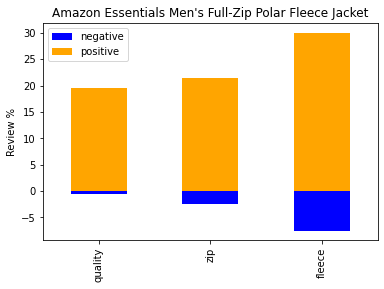

In [54]:
p_id = 1

df = pos[pos['product_id'] == p_id].reset_index()

overall_vec = pd.DataFrame(np.zeros((len(df), len(features))), columns = features)

product_vec = np.array(df2.iloc[p_id,:])

for j in range(len(df)):
  for f in range(len(features)):
    overall_vec[features[f]].iloc[j] = product_vec[f] *  df[features[f]].iloc[j]

s_pos = overall_vec.mean() * 100

df = neg[neg['product_id'] == p_id].reset_index()

overall_vec = pd.DataFrame(np.zeros((len(df), len(features))), columns = features)

product_vec = np.array(df2.iloc[p_id,:])

for j in range(len(df)):
  for f in range(len(features)):
    overall_vec[features[f]].iloc[j] = product_vec[f] *  df[features[f]].iloc[j]

name = review_mapping[review_mapping['prouduct_id'] == p_id]['product_name'].values[0]
print("\n\n")
s = overall_vec.mean() * 100
s[s < 0].plot(kind = 'bar', title = name, color = 'blue', label = 'negative')
s_pos[s_pos > 0].plot(kind = 'bar', title = name, color = 'orange', label = 'positive')
plt.ylabel("Review %")
plt.legend()
plt.show()